In [1]:
## Intra-class correlation

In [2]:
## Pairwise correlation of heatmaps, get max and min correlations to check consistency both across subjects and across regions

In [3]:
## potentially write up and send it to Neuroimage

In [4]:
import pingouin as pg
import pandas as pd
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import seaborn
import math
import itertools
from scipy.stats import median_absolute_deviation as mad
from scipy.stats import pearsonr

D:\anaconda\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
# Reading in Rscore files by stack and concatenate them
runs = ['run1','run2','run3','run4']
all_Rscore = []

for run in runs:
    file = 'E:/projects/connectome/results/'+run+'/Rscore/Rscore_1.csv'
    Rscore = pd.read_csv(file)
    Rscore = Rscore.rename(columns={'Unnamed: 0':'ID'})
    Rscore = Rscore.set_index('ID')
    for i in range(2,21):
        file = 'E:/projects/connectome/results/'+run+'/Rscore/Rscore_'+str(i)+'.csv'
        tmp2 = pd.read_csv(file)
        tmp2 = tmp2.rename(columns={'Unnamed: 0':'ID'})
        tmp2 = tmp2.set_index('ID')
        Rscore = pd.concat([Rscore, tmp2],sort=True)

    # sort regions by region number
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:int(reg.strip('region '))})
    Rscore = Rscore.sort_index(axis=1)
    for reg in Rscore:
        Rscore = Rscore.rename(columns={reg:'region '+str(reg)})
    
    # sort by subject ID and save to file
    Rscore.to_csv('E:/projects/connectome/results/'+run+'/Rscore/Rscore_all.csv',index=True)
    
    all_Rscore.append(Rscore)

#### Since run1 only has 810 subjects, we subset these subjects from run2,run3,run4 and compute ICC for those 810 subjects

In [6]:
sub_IDs = all_Rscore[0].index

In [7]:
for i in range(1,4):
    all_Rscore[i] = all_Rscore[i].loc[sub_IDs]

# Compute Intraclass Correlation for all subjects and regions collectively

#### We will use the function icc() from module 'pingouin' to compute this, but first we have to make sure that the input data to icc() is appropriately formated. Lets take a look at the sample input of icc()

In [8]:
pg.read_dataset('icc').head(10)

,Wine,Judge,Scores
0,1,A,1
1,2,A,1
2,3,A,3
3,4,A,6
4,5,A,6
5,6,A,7
6,7,A,8
7,8,A,9
8,1,B,2
9,2,B,3


In [9]:
# define product sets for convenient extraction of data from multiarray all_Rscore[[]]
# since we put sub_and_reg, run and correponding Rscore in three different vectors before creating dataframe
# we use sorted() to make sure that the values line up 

prod_sub_reg_run = sorted(list(itertools.product(all_Rscore[0].index,all_Rscore[0].columns,range(1,5))))     
prod_sub_reg = list(itertools.product(all_Rscore[0].index,all_Rscore[0].columns))
# 
df_index = sorted(prod_sub_reg*4)

In [10]:
runs = []
for tmp in list(itertools.repeat([1,2,3,4],810*160)):
    runs.extend(tmp)

In [11]:
all_Rscore_to_vec = []
for sub_reg_run in prod_sub_reg_run:
    sub = sub_reg_run[0]
    reg = sub_reg_run[1]
    run = sub_reg_run[2]
    
    all_Rscore_to_vec.append(all_Rscore[run-1][reg].loc[sub])

In [12]:
df = pd.DataFrame({'sub and reg':df_index, 'run':runs, 'Rscore':all_Rscore_to_vec})

#### So the final data frame that we will feed into the function looks like

In [13]:
df.head(10)

,sub and reg,run,Rscore
0,"(sub102513, region 1)",1,0.439657
1,"(sub102513, region 1)",2,0.380138
2,"(sub102513, region 1)",3,0.190480
3,"(sub102513, region 1)",4,0.218381
4,"(sub102513, region 10)",1,0.408745
5,"(sub102513, region 10)",2,0.448898
6,"(sub102513, region 10)",3,0.183966
7,"(sub102513, region 10)",4,0.264663
8,"(sub102513, region 100)",1,0.417422
9,"(sub102513, region 100)",2,0.424707


In [14]:
icc = pg.intraclass_corr(data=df, targets='sub and reg', raters='run',ratings='Rscore')

In [15]:
icc.index = icc['Type']

In [16]:
col_subset = ['ICC','F','pval','CI95%'] 

In [17]:
icc[col_subset]

,ICC,F,pval,CI95%
Type,,,,
ICC1,0.868998,27.533910,0.0,"[0.87, 0.87]"
ICC2,0.869038,27.790253,0.0,"[0.87, 0.87]"
ICC3,0.870089,27.790253,0.0,"[0.87, 0.87]"
ICC1k,0.963681,27.533910,0.0,"[0.96, 0.96]"
ICC2k,0.963693,27.790253,0.0,"[0.96, 0.96]"
ICC3k,0.964016,27.790253,0.0,"[0.96, 0.96]"


# Subject-wise Intraclass Correlation

#### Next we compute ICC across all subjects, treating all 4 runs as raters. Basically we gather R scores for all 160 regions for a subject, each of the region has an R score in a run, then we compute ICC subject to subject.

In [18]:
subwise_ICC1 = []
subwise_ICC2 = []
subwise_ICC3 = []
subwise_ICC2K = []
subwise_ICC3K = []
subwise_ICC1K = []

sub_IDs = sorted(list(all_Rscore[0].index))
regs = sorted(list(all_Rscore[0].columns)*4)
runs = []
for tmp in list(itertools.repeat([1,2,3,4],160)):
    runs.extend(tmp)
    
for sub in sub_IDs:
    vectorized_Rscore = []    
    for reg in all_Rscore[0].columns:    
        for run in range(0,4):
            vectorized_Rscore.append(all_Rscore[run][reg].loc[sub])
    
    sub_df = pd.DataFrame({'reg':regs, 'run':runs, 'Rscore':vectorized_Rscore})
    
    icc = pg.intraclass_corr(data=sub_df, targets='reg', raters='run',ratings='Rscore')
    subwise_ICC1.append(icc['ICC'].loc[0])
    subwise_ICC2.append(icc['ICC'].loc[1])
    subwise_ICC3.append(icc['ICC'].loc[2])
    subwise_ICC1K.append(icc['ICC'].loc[3])
    subwise_ICC2K.append(icc['ICC'].loc[4])
    subwise_ICC3K.append(icc['ICC'].loc[5])       

In [19]:
sub_df

,reg,run,Rscore
0,region 1,1,0.272927
1,region 1,2,0.311609
2,region 1,3,0.605599
3,region 1,4,0.287501
4,region 10,1,0.294201
...,...,...,...
635,region 98,4,0.160230
636,region 99,1,0.156829
637,region 99,2,0.088045
638,region 99,3,0.159952


In [20]:
subwise_ICC = pd.DataFrame({'ICC1':subwise_ICC1,'ICC2':subwise_ICC2,'ICC3':subwise_ICC3,'ICC1K':subwise_ICC1K,'ICC2K':subwise_ICC2K,'ICC3K':subwise_ICC3K})

In [21]:
subwise_ICC.index = ['sub'+str(x) for x  in range(1,len(sub_IDs)+1)]

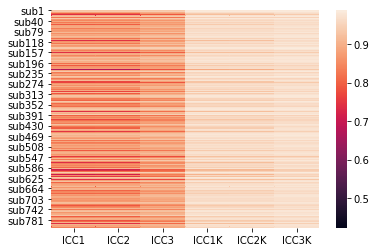

In [22]:
seaborn.heatmap(subwise_ICC)
plt.show()

In [23]:
subwise_ICC_min = []
subwise_ICC_max = []
subwise_ICC_median = []
subwise_ICC_mad = []

criteria = ['ICC1','ICC2','ICC3','ICC1K','ICC2K','ICC3K']
for criterion in criteria:
    subwise_ICC_min.append(min(subwise_ICC[criterion]))
    subwise_ICC_max.append(max(subwise_ICC[criterion]))
    subwise_ICC_median.append(np.median(subwise_ICC[criterion]))
    subwise_ICC_mad.append(mad(subwise_ICC[criterion]))

In [24]:
subwise_ICC_stats = pd.DataFrame({'subject_level_min':subwise_ICC_min,'subject_level_max':subwise_ICC_max,'subject_level_median':subwise_ICC_median,'subject_level_mad':subwise_ICC_mad})

In [25]:
subwise_ICC_stats.index = criteria

#### Here we are summarizing the min, max, median and standard deviation of the ICC's computed for subjects

In [26]:
subwise_ICC_stats

,subject_level_min,subject_level_max,subject_level_median,subject_level_mad
ICC1,0.422762,0.949804,0.868888,0.048850
ICC2,0.470297,0.949830,0.870055,0.048185
ICC3,0.701309,0.951845,0.890509,0.032322
ICC1K,0.745518,0.986960,0.963647,0.014892
ICC2K,0.780288,0.986967,0.964006,0.014486
ICC3K,0.903770,0.987510,0.970178,0.009647


# Region-wise Intraclass Correlation

In [27]:
regwise_ICC1 = []
regwise_ICC2 = []
regwise_ICC3 = []
regwise_ICC1K = []
regwise_ICC2K = []
regwise_ICC3K = []

sub_IDs = sorted(list(all_Rscore[0].index))
subs = list(sorted(list(all_Rscore[0].index)*4))
runs = []
for tmp in list(itertools.repeat([1,2,3,4],810)):
    runs.extend(tmp)

In [28]:
for reg in list(all_Rscore[0].columns):    
    vectorized_Rscore = []    
    for sub in sub_IDs:
        for run in range(0,4):
            vectorized_Rscore.append(all_Rscore[run][reg].loc[sub])
    
    reg_df = pd.DataFrame({'sub':subs, 'run':runs, 'Rscore':vectorized_Rscore})
    
    icc = pg.intraclass_corr(data=reg_df, targets='sub', raters='run',ratings='Rscore')
    regwise_ICC1.append(icc['ICC'].loc[0])
    regwise_ICC2.append(icc['ICC'].loc[1])
    regwise_ICC3.append(icc['ICC'].loc[2])
    regwise_ICC1K.append(icc['ICC'].loc[3])
    regwise_ICC2K.append(icc['ICC'].loc[4])
    regwise_ICC3K.append(icc['ICC'].loc[5])    

In [29]:
regwise_ICC = pd.DataFrame({'ICC1':regwise_ICC1,'ICC2':regwise_ICC2,'ICC3':regwise_ICC3,'ICC1K':regwise_ICC1K,'ICC2K':regwise_ICC2K,'ICC3K':regwise_ICC3K})

In [30]:
regwise_ICC.index = list(all_Rscore[0].columns)

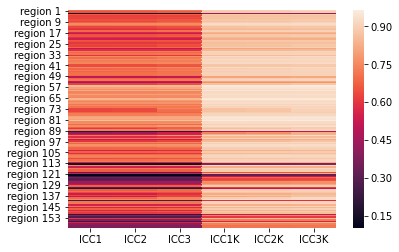

In [31]:
seaborn.heatmap(regwise_ICC)
plt.show()

In [32]:
regwise_ICC_min = []
regwise_ICC_max = []
regwise_ICC_median = []
regwise_ICC_mad = []

criteria = ['ICC1','ICC2','ICC3','ICC1K','ICC2K','ICC3K']
for criterion in criteria:
    regwise_ICC_min.append(min(regwise_ICC[criterion]))
    regwise_ICC_max.append(max(regwise_ICC[criterion]))
    regwise_ICC_median.append(np.median(regwise_ICC[criterion]))
    regwise_ICC_mad.append(mad(regwise_ICC[criterion]))

In [33]:
regwise_ICC_stats = pd.DataFrame({'region_level_min':regwise_ICC_min,'region_level_max':regwise_ICC_max,'region_level_median':regwise_ICC_median,'region_level_mad':regwise_ICC_mad})

In [34]:
regwise_ICC_stats.index = criteria

#### Here we are summarizing the min, max, median and standard deviation of the ICC's computed for regions

In [35]:
regwise_ICC_stats

,region_level_min,region_level_max,region_level_median,region_level_mad
ICC1,0.103577,0.868654,0.668508,0.110796
ICC2,0.106114,0.868664,0.669677,0.109736
ICC3,0.107329,0.868932,0.679831,0.103326
ICC1K,0.316088,0.963575,0.889702,0.047278
ICC2K,0.321961,0.963578,0.890222,0.046732
ICC3K,0.324750,0.963661,0.894664,0.042709


# Cronbach's Alpha

#### We will also investigate the concistency of results of all 4 runs by computing the Cronbach's Alpha

In [36]:
prod_sub_reg = sorted(list(itertools.product(all_Rscore[0].index,all_Rscore[0].columns)))

In [37]:
vectorized_Rscores = []
for run in range(0,4):
    vectorized_Rscore = []
    for (sub,reg) in prod_sub_reg:
        vectorized_Rscore.append(all_Rscore[run][reg].loc[sub])
    vectorized_Rscores.append(vectorized_Rscore)

In [38]:
df = pd.DataFrame({'run1':vectorized_Rscores[0],'run2':vectorized_Rscores[1],'run3':vectorized_Rscores[2],'run4':vectorized_Rscores[3]})

#### We use Spearman correlation here instead of Pearson correlation because it is more important to capture the similarity between ranks of different values instead of capturing the overall trend

In [39]:
pairwise_corrs = pg.pairwise_corr(df, method='spearman', tail='one-sided',padjust='bonf')  

#### By the formula, Cronbach's alpha is $\alpha=\frac{k\bar{C}}{\bar{v}+(k-1)\bar{C}}$ where $k$ is the number of runs in our case.

In [40]:
rho =np.mean(pairwise_corrs['r'])

In [41]:
alpha = 4*rho/(1+3*rho)

In [42]:
print("The normalized Cronbach's alpha is equal to {}".format(alpha))

The normalized Cronbach's alpha is equal to 0.9620001160022581


## Subject-wise Interclass Correlation

#### Here we compute all correlations between the runs (4 tuns in total so a total of 6 possible correlations) for both each subject and each region. We then compute for each subject or each region the min,max and mean among the 6 possible correlations.

In [43]:
sub_corr12 = [] # correlation on subject level between run1 and run2
sub_corr13 = [] # correlation on subject level between run1 and run3
sub_corr14 = [] # correlation on subject level between run1 and run4
sub_corr23 = [] # correlation on subject level between run2 and run3
sub_corr24 = [] # correlation on subject level between run2 and run4
sub_corr34 = [] # correlation on subject level between run3 and run4

In [44]:
for sub in sub_IDs:
    sub_corr12.append(pearsonr(all_Rscore[0].loc[sub],all_Rscore[1].loc[sub])[0])
    sub_corr13.append(pearsonr(all_Rscore[0].loc[sub],all_Rscore[2].loc[sub])[0])
    sub_corr14.append(pearsonr(all_Rscore[0].loc[sub],all_Rscore[3].loc[sub])[0])
    sub_corr23.append(pearsonr(all_Rscore[1].loc[sub],all_Rscore[2].loc[sub])[0])
    sub_corr24.append(pearsonr(all_Rscore[1].loc[sub],all_Rscore[3].loc[sub])[0])
    sub_corr34.append(pearsonr(all_Rscore[2].loc[sub],all_Rscore[3].loc[sub])[0])
    
sub_corr12 = pd.DataFrame(sub_corr12,index=sub_IDs,columns=['run1_vs_run2'])
sub_corr13 = pd.DataFrame(sub_corr13,index=sub_IDs,columns=['run1_vs_run3'])
sub_corr14 = pd.DataFrame(sub_corr14,index=sub_IDs,columns=['run1_vs_run4'])
sub_corr23 = pd.DataFrame(sub_corr23,index=sub_IDs,columns=['run2_vs_run3'])
sub_corr24 = pd.DataFrame(sub_corr24,index=sub_IDs,columns=['run2_vs_run4'])
sub_corr34 = pd.DataFrame(sub_corr34,index=sub_IDs,columns=['run3_vs_run4'])

In [45]:
sub_corr = pd.concat([sub_corr12,sub_corr13,sub_corr14,sub_corr23,sub_corr24,sub_corr34],axis=1,sort=True)

In [46]:
sub_corr['median'] = sub_corr.median(axis=1)
sub_corr['min'] = sub_corr.min(axis=1)
sub_corr['max'] = sub_corr.max(axis=1)
sub_corr['mad'] = sub_corr.mad(axis=1)

In [47]:
min_max_median = sub_corr[['median','min','max']]

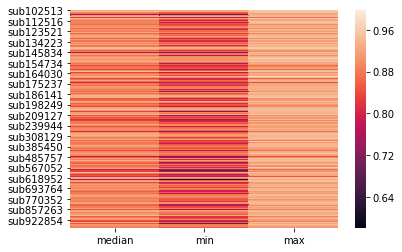

In [48]:
seaborn.heatmap(min_max_median)
plt.show()

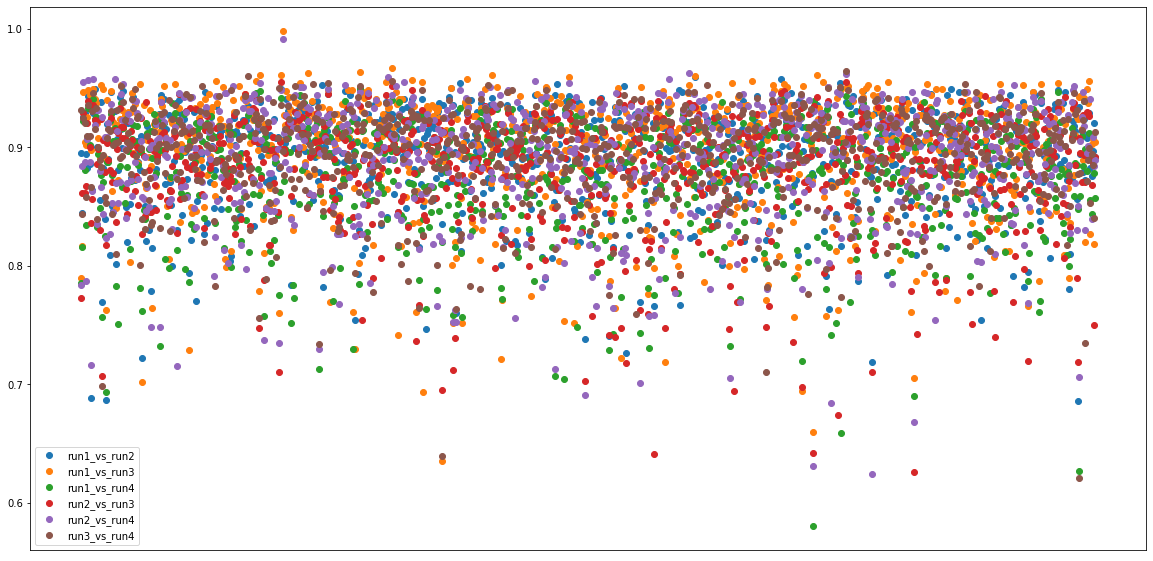

In [49]:
plt.figure(figsize=(20,10))
plt.plot(range(810),sub_corr.T.loc['run1_vs_run2'],'o',label='run1_vs_run2')
plt.plot(range(810),sub_corr.T.loc['run1_vs_run3'],'o',label='run1_vs_run3')
plt.plot(range(810),sub_corr.T.loc['run1_vs_run4'],'o',label='run1_vs_run4')
plt.plot(range(810),sub_corr.T.loc['run2_vs_run3'],'o',label='run2_vs_run3')
plt.plot(range(810),sub_corr.T.loc['run2_vs_run4'],'o',label='run2_vs_run4')
plt.plot(range(810),sub_corr.T.loc['run3_vs_run4'],'o',label='run3_vs_run4')
plt.legend()
#plt.title('Subject-level Interclass Correlation for Run-pairs',fontsize=40)
plt.xticks([])
plt.show()

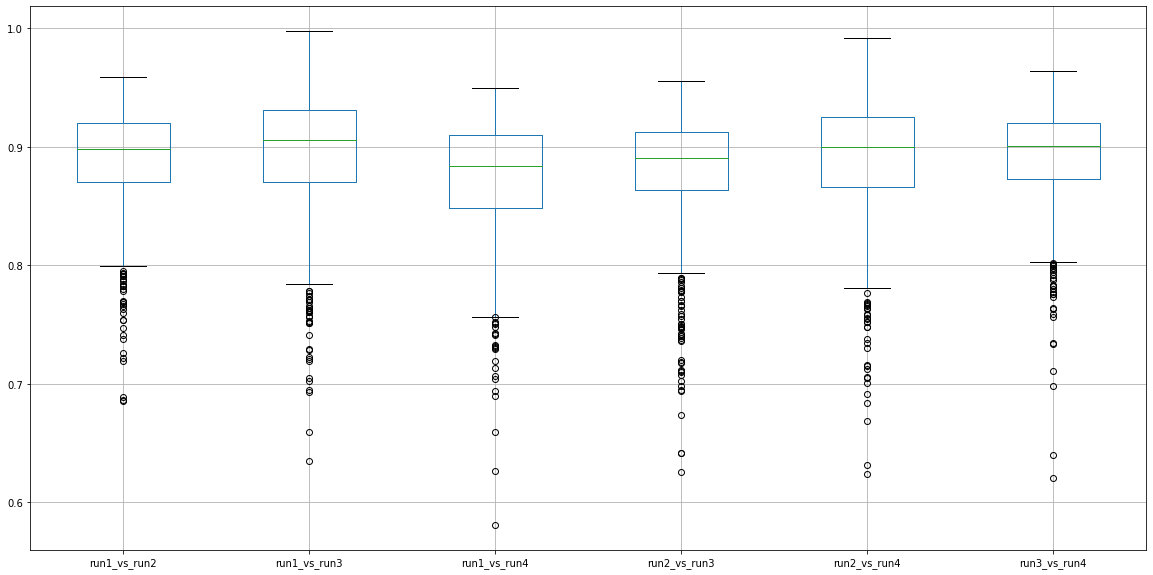

In [50]:
sub_corr.boxplot(['run1_vs_run2','run1_vs_run3','run1_vs_run4','run2_vs_run3','run2_vs_run4','run3_vs_run4'],figsize=(20,10))
#plt.title('Subject-level Interclass Correlation for Run-pairs',fontsize=40)
plt.show()

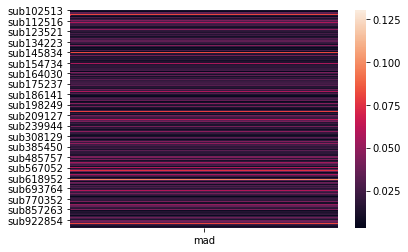

In [51]:
seaborn.heatmap(sub_corr[['mad']])
plt.show()

## Region-wise Interclass Correlation

In [52]:
reg_corr12 = [] # correlation on region level between run1 and run2
reg_corr13 = [] # correlation on region level between run1 and run3
reg_corr14 = [] # correlation on region level between run1 and run4
reg_corr23 = [] # correlation on region level between run2 and run3
reg_corr24 = [] # correlation on region level between run2 and run4
reg_corr34 = [] # correlation on region level between run3 and run4

In [53]:
for reg in all_Rscore[0].columns:
    reg_corr12.append(pearsonr(all_Rscore[0][reg],all_Rscore[1][reg])[0])
    reg_corr13.append(pearsonr(all_Rscore[0][reg],all_Rscore[2][reg])[0])
    reg_corr14.append(pearsonr(all_Rscore[0][reg],all_Rscore[3][reg])[0])
    reg_corr23.append(pearsonr(all_Rscore[1][reg],all_Rscore[2][reg])[0])
    reg_corr24.append(pearsonr(all_Rscore[1][reg],all_Rscore[3][reg])[0])
    reg_corr34.append(pearsonr(all_Rscore[2][reg],all_Rscore[3][reg])[0])
    
reg_corr12 = pd.DataFrame(reg_corr12,index=all_Rscore[0].columns,columns=['run1_vs_run2'])
reg_corr13 = pd.DataFrame(reg_corr13,index=all_Rscore[0].columns,columns=['run1_vs_run3'])
reg_corr14 = pd.DataFrame(reg_corr14,index=all_Rscore[0].columns,columns=['run1_vs_run4'])
reg_corr23 = pd.DataFrame(reg_corr23,index=all_Rscore[0].columns,columns=['run2_vs_run3'])
reg_corr24 = pd.DataFrame(reg_corr24,index=all_Rscore[0].columns,columns=['run2_vs_run4'])
reg_corr34 = pd.DataFrame(reg_corr34,index=all_Rscore[0].columns,columns=['run3_vs_run4'])

In [54]:
reg_corr = pd.concat([reg_corr12,reg_corr13,reg_corr14,reg_corr23,reg_corr24,reg_corr34],axis=1)

In [55]:
reg_corr

,run1_vs_run2,run1_vs_run3,run1_vs_run4,run2_vs_run3,run2_vs_run4,run3_vs_run4
region 1,0.769513,0.704310,0.670732,0.707832,0.682962,0.784697
region 2,0.705634,0.637400,0.660190,0.663029,0.613808,0.744284
region 3,0.192264,0.134224,0.186951,0.133739,0.160643,0.134756
region 4,0.741322,0.633643,0.639581,0.657397,0.644261,0.760373
region 5,0.709193,0.585483,0.583917,0.605885,0.565667,0.711533
...,...,...,...,...,...,...
region 156,0.233592,0.313392,0.216255,0.142887,0.189222,0.356176
region 157,0.582153,0.575724,0.512919,0.509129,0.599532,0.600902
region 158,0.380356,0.444120,0.380540,0.371887,0.429542,0.457291
region 159,0.415993,0.332153,0.358553,0.352620,0.354634,0.511403


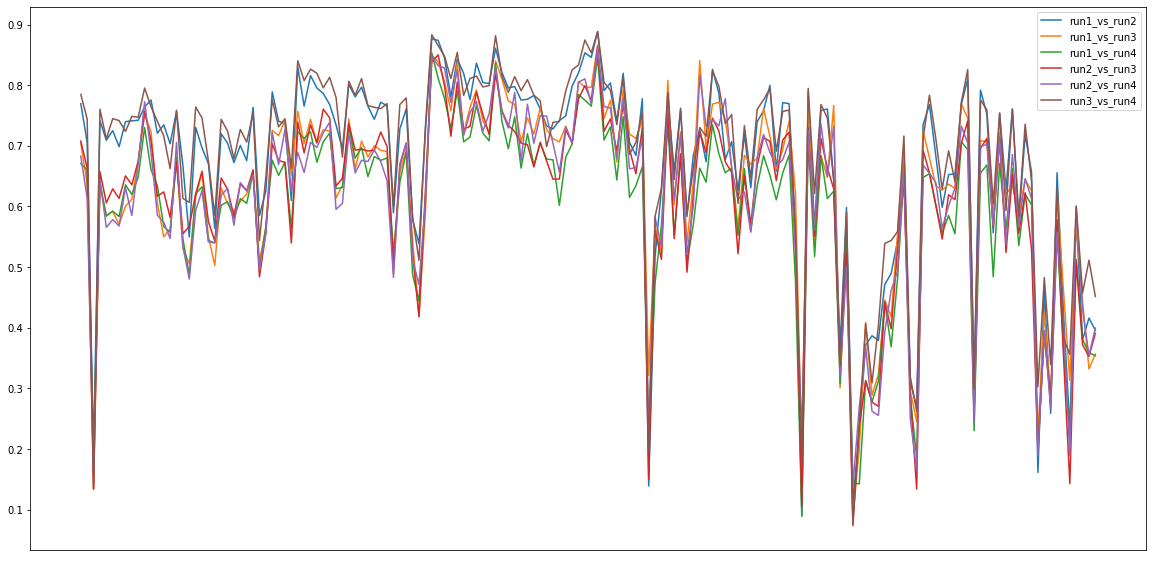

In [56]:
plt.figure(figsize=(20,10))
plt.plot(reg_corr.T.loc['run1_vs_run2'],label='run1_vs_run2')
plt.plot(reg_corr.T.loc['run1_vs_run3'],label='run1_vs_run3')
plt.plot(reg_corr.T.loc['run1_vs_run4'],label='run1_vs_run4')
plt.plot(reg_corr.T.loc['run2_vs_run3'],label='run2_vs_run3')
plt.plot(reg_corr.T.loc['run2_vs_run4'],label='run2_vs_run4')
plt.plot(reg_corr.T.loc['run3_vs_run4'],label='run3_vs_run4')
plt.legend()
#plt.title("Region-level Interclass Correlation for Run-pairs",fontsize=40)
plt.xticks([])
plt.show()

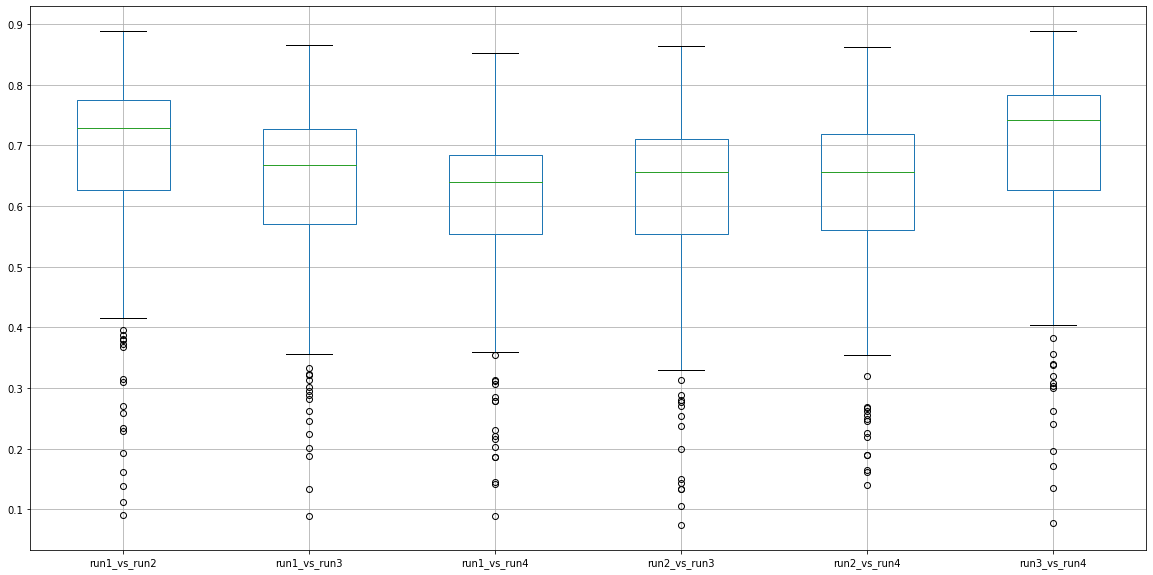

In [57]:
reg_corr.boxplot(['run1_vs_run2','run1_vs_run3','run1_vs_run4','run2_vs_run3','run2_vs_run4','run3_vs_run4'],figsize=(20,10))
#plt.title('Region-level Interclass Correlation for Run-pairs',fontsize=40)
plt.show()

In [58]:
reg_corr['min'] = reg_corr.min(axis=1)
reg_corr['max'] = reg_corr.max(axis=1)
reg_corr['median'] = reg_corr.median(axis=1)

In [59]:
reg_corr

,run1_vs_run2,run1_vs_run3,run1_vs_run4,run2_vs_run3,run2_vs_run4,run3_vs_run4,min,max,median
region 1,0.769513,0.704310,0.670732,0.707832,0.682962,0.784697,0.670732,0.784697,0.706071
region 2,0.705634,0.637400,0.660190,0.663029,0.613808,0.744284,0.613808,0.744284,0.661610
region 3,0.192264,0.134224,0.186951,0.133739,0.160643,0.134756,0.133739,0.192264,0.147699
region 4,0.741322,0.633643,0.639581,0.657397,0.644261,0.760373,0.633643,0.760373,0.650829
region 5,0.709193,0.585483,0.583917,0.605885,0.565667,0.711533,0.565667,0.711533,0.595684
...,...,...,...,...,...,...,...,...,...
region 156,0.233592,0.313392,0.216255,0.142887,0.189222,0.356176,0.142887,0.356176,0.224924
region 157,0.582153,0.575724,0.512919,0.509129,0.599532,0.600902,0.509129,0.600902,0.578938
region 158,0.380356,0.444120,0.380540,0.371887,0.429542,0.457291,0.371887,0.457291,0.405041
region 159,0.415993,0.332153,0.358553,0.352620,0.354634,0.511403,0.332153,0.511403,0.356593


In [60]:
min_max_mean = reg_corr[['median','min','max']]

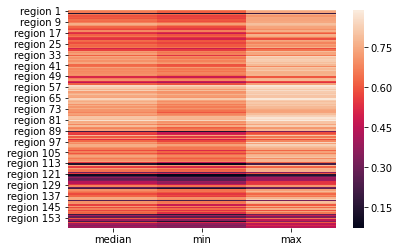

In [61]:
seaborn.heatmap(min_max_mean)
plt.show()